## Instruction
In this notebook, we will complete backtest which is the last step.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import scipy
from scipy.optimize import fmin_l_bfgs_b
from sklearn.decomposition import PCA

from statistics import median
from scipy.stats import gaussian_kde, zscore
from statsmodels.formula.api import ols

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 4]

import warnings
warnings.filterwarnings('ignore')

### Load Factors
We have factors store in csv file which process and combine from privious steps. Pick up backtest time from 2022.4 - 2022.3

In [2]:
#fundamental_df = pd.read_csv('tmp_factor.csv').iloc[:,1:]
universe_raw = pd.read_csv('AI_data/factors_AI_108.csv').iloc[:,1:]
universe_raw['date'] = pd.to_datetime(universe_raw['trade_date'], format='%Y%m%d')
universe = universe_raw.set_index(['date']).sort_values(by=['date'])
universe = universe.fillna(method='ffill').fillna(0.)
print(universe.shape)

(86701, 10)


In [3]:
# only use from 2022.6 to 2023.4, here from 2022.5 in order to generate risk model from history
universe = universe.loc[universe['trade_date']>=20220401]
universe.columns

Index(['ts_code', 'trade_date', 'name', 'industry', 'close', 'log-ret',
       'alpha_atr14', 'alpha_kama', 'alpha_AI', 'alpha_083'],
      dtype='object')

### Alignment Tickers
fill data to history by 0 in order to get align ticker marix data each day.

In [4]:
def init_holding(df):
    ticker_list = df.ts_code.unique()
    calendar = df.trade_date.unique()
    for dt in tqdm(calendar):
        day_df = df.loc[df.trade_date == dt]
        diff_tickers = list(set(ticker_list) - set(day_df.ts_code.unique()))
        if len(diff_tickers) > 0:
            for ticker in diff_tickers:
                check_df = df.loc[df.ts_code==ticker].iloc[0,:]
                # date ts_code trade_date name industry close log-ret 'alpha_atr14', 'alpha_kama', 'alpha_AI'
                data = [pd.to_datetime(dt, format='%Y%m%d'), ticker, dt, check_df['name'],
                        check_df['industry'], 0., 0., 0., 0., 0., 0.]
                data = pd.DataFrame(data=data, index=np.append(['date'], df.columns)).T.set_index(['date'])
                df = df.append(data)
    df = df.sort_values(by=['date']) 
    return df

universe = init_holding(universe)

100%|█████████████████████████████████████████| 258/258 [00:02<00:00, 87.45it/s]


### Rescale AI Factor

In [5]:
def rescale_(data):
    # resize from -1 to 1
    feature = 'alpha_AI'
    data[feature] = data[feature] - data[feature].median()
    max_val = data[feature].median() + 3.5*data[feature].std()
    min_val = data[feature].median() - 3.5*data[feature].std()
    data[feature] = np.where(data[feature]>max_val, max_val, 
                           np.where(data[feature]<min_val, min_val, data[feature]))
    data[feature] = np.where(data[feature]>0, data[feature]/data[feature].max(),
                             np.where(data[feature]<0, data[feature]/(-data[feature].min()), 0.))
    return data

# need to fix excuted in privious step
def zscore_AI(data):
    feature = 'alpha_AI'
    data[feature] = data[feature].astype(np.float32)
    data[[feature]] = data[[feature]].apply(zscore)
    data[feature] = np.where(data[feature]>0, data[feature]/data[feature].max(), 
                                np.where(data[feature]<0, data[feature]/-data[feature].min(), 0.))
    return data

#universe_z = universe.groupby('trade_date').apply(rescale_)
universe_z = universe.groupby('trade_date')[universe.columns].apply(zscore_AI)

-0.015620219


<AxesSubplot:>

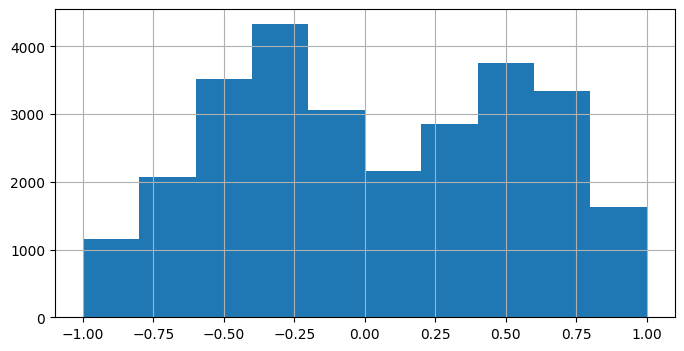

In [6]:
print(universe_z['alpha_AI'].median())
universe_z['alpha_AI'].hist()

In [7]:
universe['alpha_kama'] = np.where(universe['alpha_AI']<-0.5, 0, universe['alpha_kama'])
universe['alpha_atr14'] = np.where(universe['alpha_AI']<-0.5, 0, universe['alpha_atr14'])

### Factor Exposures and Factor Returns
The facort values in cross section should view as a type of exposure. We can calculate factor returns bettwen exposures of each ticker and daily return. We also did this in backtestig animate notebook.

In [8]:
## shif return 5 days
all_factors = universe_z.copy(deep=True)
#all_factors = all_factors.sort_values(by=['date'])
def return_handle(df):
    df['returns_2'] = df['log-ret'].shift(-2)
    return df
all_factors = all_factors.groupby('ts_code').apply(return_handle)
all_factors = all_factors.replace([np.inf, -np.inf], np.nan).fillna(0.).sort_values(by=['trade_date', 'ts_code'])
print(universe.shape, all_factors.shape)

(27864, 10) (27864, 11)


In [9]:
def wins(x,a,b):
    return np.where(x <= a,a, np.where(x >= b, b, x))

def get_formula(factors, Y):
    L = ["0"]
    L.extend(factors)
    return Y + " ~ " + " + ".join(L)

def factors_from_names(n, name):
    return list(filter(lambda x: name in x, n))

def estimate_factor_returns(df, name='alpha_'): 
    ## winsorize returns for fitting 
    estu = df.copy(deep=True)
    estu['returns_2'] = wins(estu['returns_2'], -0.2, 0.2)
    all_factors = factors_from_names(list(df), name)
    results = pd.Series()
    for factor_name in all_factors:
        form = get_formula([factor_name], "returns_2")
        model = ols(form, data=estu)
        result = model.fit()
        results = results.append(result.params)
    return results

estimate_factor_returns(all_factors.loc[all_factors['trade_date']==20220601])

alpha_atr14    0.007195
alpha_kama    -0.009624
alpha_AI      -0.004518
alpha_083     -0.030816
dtype: float64

In [263]:
base_field = ['ts_code','trade_date','name', 'industry', 'close', 'log-ret']
alpha_field = ['alpha_atr14', 'alpha_kama', 'alpha_083', 'alpha_AI'] 
date_and_code = [ 'trade_date','ts_code', 'returns_2']

start_time = 20220501
alpha_df = all_factors[alpha_field + date_and_code].copy(deep=True)
alpha_df = alpha_df.loc[alpha_df['trade_date']>=start_time]
calendar = alpha_df.trade_date.unique() # int64

## only for positive estimate
# for feature in alpha_field:
#     alpha_df[feature] = np.where(alpha_df[feature]>0, alpha_df[feature], 0.)

facret = {}
for dt in tqdm(calendar, desc='regression factor returns'):
    facret[dt] = estimate_factor_returns(alpha_df.loc[alpha_df['trade_date']==dt])
facret[calendar[-1]]

regression factor returns: 100%|██████████████| 239/239 [00:05<00:00, 43.08it/s]


alpha_atr14    0.0
alpha_kama     0.0
alpha_083      0.0
alpha_AI       0.0
dtype: float64

#### Veiw Factor Returns

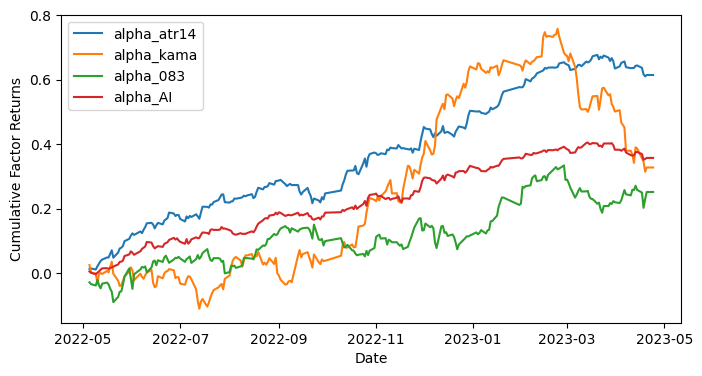

In [264]:
date_list = alpha_df.index.unique()
facret_df = pd.DataFrame(index = date_list)

for ii, dt in zip(calendar,date_list): 
    for alp in alpha_field: 
        facret_df.at[dt, alp] = facret[ii][alp]

for column in facret_df.columns:
    plt.plot(facret_df[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Cumulative Factor Returns')
plt.show()

In [12]:
universe = universe.loc[universe['trade_date']>=20220401]
all_factors = all_factors.loc[all_factors['trade_date']>=20220401]

In [13]:
all_factors.tail()

,ts_code,trade_date,name,industry,close,log-ret,alpha_atr14,alpha_kama,alpha_AI,alpha_083,returns_2
date,,,,,,,,,,,
2023-04-24,688358.SH,20230424,祥生医疗,医疗保健,53.23,-0.002814,-0.375090,-0.037230,-0.677689,-0.081701,0.0
2023-04-24,688579.SH,20230424,山大地纬,软件服务,16.28,-0.012817,-0.112821,-0.011043,-0.199471,0.158831,0.0
2023-04-24,688589.SH,20230424,力合微,半导体,46.63,0.006886,-0.352965,-0.024255,-0.408431,-0.102085,0.0
2023-04-24,688655.SH,20230424,迅捷兴,元器件,12.54,-0.025198,0.575550,-0.325016,0.631053,0.163914,0.0
2023-04-24,688799.SH,20230424,华纳药厂,化学制药,39.71,0.024472,0.047886,-0.002401,-0.286072,-0.001479,0.0


### PCA model
We use PCA algorithm to estimate risk

In [14]:
from sklearn.decomposition import PCA

class RiskModel(object):
    def __init__(self, returns, num_factor_exposures, ann_factor=250):
        
        self.num_factor_exposures = num_factor_exposures
        self.pca = PCA(n_components=num_factor_exposures, svd_solver='full')
        self.pca.fit(returns)
        
        self.factor_betas_ = self.factor_betas(self.pca, returns.columns.values, np.arange(num_factor_exposures))
        self.factor_returns_ = self.factor_returns(self.pca, returns, returns.index, np.arange(num_factor_exposures))
        self.estimate_returns = self.estimate_returns(self.factor_returns_, self.factor_betas_, returns)
        self.factor_cov_matrix_ = self.factor_cov_matrix(self.factor_returns_, ann_factor)
        
        self.idiosyncratic_var_matrix_ = self.idiosyncratic_var_matrix(returns, self.estimate_returns, ann_factor)
        self.idiosyncratic_var_vector = pd.DataFrame(data=np.diag(self.idiosyncratic_var_matrix_),
                                                     index=returns.columns)
    
    # got new exposure expressed by pca model
    def factor_betas(self, pca, factor_beta_indices, factor_beta_columns):
        return pd.DataFrame(pca.components_.T, factor_beta_indices, factor_beta_columns)
    
    # got new factor returns expressed by pca model
    def factor_returns(self, pca, returns, factor_return_indices, factor_return_columns):
        return pd.DataFrame(pca.transform(returns), factor_return_indices, factor_return_columns)
    
    # got new factor covariance matirx by pca expressed returns
    def factor_cov_matrix(self, factor_returns, ann_factor):
        return np.diag(factor_returns.var(axis=0, ddof=1) * ann_factor)
    
    def estimate_returns(self, factor_returns, factor_betas, returns):
        return pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    
    # calculate idiosyncratic need to got factor_returns, factor_betas which calculate by pca model first
    def idiosyncratic_var_matrix(self, returns, estimate_returns, ann_factor):
        residuals = returns - estimate_returns
        return pd.DataFrame(np.diag(np.var(residuals))*ann_factor, returns.columns, returns.columns)
    
    def plot_principle_risk(self):
        # Make the bar plot
        plt.bar(np.arange(self.num_factor_exposures), self.pca.explained_variance_ratio_)

In [15]:
def rolling_df_by_day(df, start_time):
    pca_time_window = len(df.loc[df['trade_date']<start_time].trade_date.unique())
    print(f'pca window_len is {pca_time_window}')
    #trade_date_list = df.loc[df['trade_date']>=start_time].trade_date.unique()
    all_date_list = df.trade_date.unique()
    for start_i in range(len(all_date_list)):
        start_date = all_date_list[start_i]
        if start_i + pca_time_window >= len(all_date_list):
            break
        end_date = all_date_list[start_i + pca_time_window]
        yield end_date, df.loc[(df['trade_date']>=start_date) & (df['trade_date']<=end_date)]
        
def risk_by_PCA(returns_df):
    for col in returns_df.columns:
        returns_df[col] = np.where(returns_df[col]<0, returns_df[col], 0.)
    
    # Set the number of factor exposures (principal components) for the PCA algorithm
    num_factor_exposures = 5
    # Create a RiskModel object
    rm = RiskModel(returns_df, num_factor_exposures)
    
    B = rm.factor_betas_
    F = rm.factor_cov_matrix_
    S = rm.idiosyncratic_var_matrix_
    fr = rm.factor_returns_
    #fr = rm.estimate_returns
    
    variance = np.dot(B, F).dot(B.T) + S
    return variance, B, fr, rm.idiosyncratic_var_vector

# test
dt, df = next(rolling_df_by_day(all_factors, start_time))
returns_df = df.pivot(index='trade_date', columns='ts_code', values='log-ret').fillna(0)
variance_i, B, risk_fr, residual_i = risk_by_PCA(returns_df)
print(f'return date {dt}')
variance_i.head()

pca window_len is 19
return date 20220505


ts_code,000411.SZ,000756.SZ,000915.SZ,002322.SZ,002362.SZ,002365.SZ,002380.SZ,002462.SZ,002577.SZ,002605.SZ,...,688230.SH,688244.SH,688259.SH,688314.SH,688317.SH,688358.SH,688579.SH,688589.SH,688655.SH,688799.SH
ts_code,,,,,,,,,,,,,,,,,,,,,
000411.SZ,0.105696,0.062301,0.087683,0.085025,0.086736,0.064114,0.067942,0.071815,0.089298,0.105151,...,0.119840,0.0,0.054514,0.093626,0.107845,0.066135,0.094814,0.140871,0.118968,0.070887
000756.SZ,0.062301,0.239452,0.044740,0.002183,0.057931,0.029294,0.002590,0.032993,0.039657,0.056734,...,0.046556,0.0,0.026512,0.023436,0.027412,0.007430,0.038165,0.082529,0.041729,0.036616
000915.SZ,0.087683,0.044740,0.116473,0.105502,0.084200,0.065150,0.073321,0.063265,0.099969,0.102922,...,0.136761,0.0,0.055519,0.107675,0.108195,0.082150,0.107129,0.142537,0.136667,0.061463
002322.SZ,0.085025,0.002183,0.105502,0.171880,0.075882,0.066279,0.082825,0.059285,0.112087,0.097634,...,0.155663,0.0,0.056774,0.128189,0.102480,0.101549,0.112074,0.150863,0.140630,0.057537
002362.SZ,0.086736,0.057931,0.084200,0.075882,0.110062,0.063208,0.070380,0.068408,0.081357,0.107758,...,0.113715,0.0,0.055848,0.085044,0.127414,0.061168,0.105045,0.129383,0.141661,0.065303


In [16]:
risk_fr.iloc[-5,:]

0    0.108457
1    0.258080
2    0.104001
3   -0.120258
4   -0.078027
Name: 20220426, dtype: float64

In [17]:
h=np.array([1]*108) 
(np.dot(h, variance_i).dot(h.T))** 0.5

33.49552398395459

In [18]:
variance_all = {}
residual_df = pd.DataFrame()

for dt, df in rolling_df_by_day(all_factors, start_time):
    ticker_list = all_factors.loc[all_factors.trade_date==dt].ts_code.unique()
    df = df.loc[df.ts_code.isin(ticker_list)]
    returns_df = df.pivot(index='trade_date', columns='ts_code', values='log-ret').fillna(0)
    variance_i, B, risk_factor, residual_i = risk_by_PCA(returns_df)
    variance_all[dt] = [variance_i, B, risk_factor.iloc[-1,:]]
    residual_i['trade_date'] = df.loc[df.index[-1],'trade_date'].unique()[-1]
    residual_df = residual_df.append(residual_i)

residual_df.reset_index(inplace=True)
residual_df.columns = ['ts_code', 'residual', 'trade_date']
residual_df['residual'] = np.where(residual_df['residual'].isnull(), residual_df['residual'].median(), residual_df['residual'])
all_factors = all_factors.loc[all_factors['trade_date']>=start_time]
all_factors = all_factors.merge(residual_df, on=['trade_date','ts_code'], how='left')
#all_factors.tail()
print(residual_df.shape, all_factors.shape)

pca window_len is 19
(25812, 3) (25812, 12)


### Calculate Risk Factor Returns

In [19]:
## calculate risk factor return module
def change_risk_B_col(B):
    new_colnames = ['risk_' + str(_) for _ in B.columns if 'risk_' not in str(_)]
    if len(new_colnames) == 0:
        return B
    B_columns_map = {}
    for i, col in enumerate(B.columns):
        B_columns_map[col] = new_colnames[i]
    B = B.rename(columns=B_columns_map)
    return B

tmp = all_factors.loc[all_factors['trade_date']==20220601].sort_values(by=['ts_code'])
B = change_risk_B_col(B)
B.index.name='ts_code'
tmp = tmp.merge(B.reset_index(), on=['ts_code'], how='left')
estimate_factor_returns(tmp, name='risk_')

risk_0   -0.210629
risk_1    0.037240
risk_2   -0.008429
risk_3    0.070226
risk_4   -0.018321
dtype: float64

In [20]:
for dt in tqdm(calendar, desc='regression risk returns'):
    tmp = all_factors.loc[all_factors['trade_date']==dt].sort_values(by=['ts_code'])
    B = variance_all[dt][1]
    B = change_risk_B_col(B)
    B.index.name='ts_code'
    tmp = tmp.merge(B.reset_index(), on=['ts_code'], how='left')
    facotr_return = estimate_factor_returns(tmp, name='risk_')
    variance_all[dt][2]=facotr_return

#variance_all[calendar[-1]][2]

regression risk returns: 100%|████████████████| 239/239 [00:07<00:00, 32.21it/s]


### (Optional) Store Residual

In [21]:
#universe = universe.merge(residual_df, on=['ts_code', 'trade_date'], how='left')
#universe = universe.rename(columns={'residual': 'alpha_resi'})
#universe = universe.loc[universe['trade_date']>=start_time]

In [22]:
#universe['alpha_resi'].hist()

In [23]:
# universe['alpha_resi'] = universe['alpha_resi'] * 1000
# universe.to_csv('AI_data/factors_AI_108_residual.csv')

### Combine Factors

In [228]:
#'alpha_atr14', 'alpha_kama', 'alpha_AI'
all_factors['date'] = pd.to_datetime(all_factors['trade_date'], format='%Y%m%d')
alpha_df = all_factors.drop(columns=['returns_2']).set_index(['date', 'ts_code']).sort_index(level=['ts_code'])
#alpha_df['alpha_all'] = alpha_df['alpha_kama']
alpha_df['alpha_all'] = 0.65*alpha_df['alpha_atr14'] + 0.35*alpha_df['alpha_kama']
print(max(alpha_df['alpha_all']), min(alpha_df['alpha_all']))

1.0 -1.0


In [229]:
# for dt in alpha_df.trade_date.unique():
#     tmp = alpha_df.loc[alpha_df.trade_date==dt]
#     print(tmp.name)

### Backtest by Convex Optimization
- use `scipy.optimize.fmin_l_bfgs_b` top optimized portfolio
- lambda expressed a transaction costs weights
- aversion expressed a risk rescale weights

In [230]:
# the lambda expressed a transaction costs weights
def get_obj_func(h0, variance, alpha, Lambda=3e-6, aversion=.01): 
    def obj_func(h):
        #f = 0.5 * aversion * np.dot(h, variance).dot(h.T) - aversion * np.matmul(h, alpha) + np.dot((h-h0)**2, Lambda)
        f =  - np.matmul(h, alpha) \
             + aversion * (np.dot(h, variance).dot(h.T)) ** 0.5 \
             + np.dot((h-h0)**2, Lambda) 
             
        return f
    return obj_func

def get_grad_func(h0, variance, alpha, Lambda=3e-6, aversion=.01):
    def grad_func(h):
        #f_hat =  aversion * np.dot(variance, h) - aversion * alpha + 2 * Lambda * (h-h0)
        f_hat =  - alpha  \
                + 0.5 * aversion * np.dot(variance, h) \
                + 2 * Lambda * (h-h0) 
        return f_hat
    return grad_func

# bounds means position bounds at each row. Here I only trade for long so that bounds from 0 to 1

#start_time = 20220601
alpha_df['h_privious'] = 0.
positions = {}
calendar = alpha_df.trade_date.unique()

# get parameter
ticker_num = len(alpha_df.index.get_level_values(1).unique())
h0 = [0.] * ticker_num
bounds = [(0, 10000)] * ticker_num

for dt in calendar:
    # fill yesterday holding
    obj_df = alpha_df.loc[alpha_df.trade_date==dt]
    
    # convex optimize
    obj_func = get_obj_func(h0, variance_all[dt][0], obj_df['alpha_all'].values)
    grad_func = get_grad_func(h0, variance_all[dt][0], obj_df['alpha_all'].values)
    h_optimal, min_val, _ = fmin_l_bfgs_b(obj_func, h0, fprime=grad_func, bounds=bounds)
    #h_optimal, min_val, _ = fmin_l_bfgs_b(obj_func, h0, fprime=grad_func)
    # update optimize holding
    obj_df['h_opt'] = h_optimal
    obj_df['h_privious'] = h0
    positions[dt]= obj_df
    h0 = h_optimal

69048.98344217137 3252.0574615932037
58325.32281469136 69048.98344217137


<AxesSubplot:>

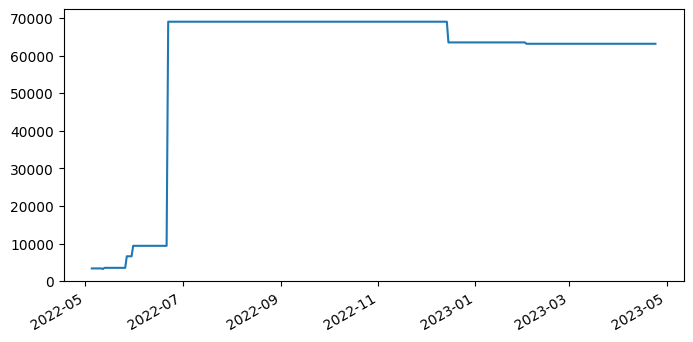

In [231]:
all_positions = []
for dt in list(positions.keys()):
    all_positions.append(positions[dt].h_opt.sum())
print(max(all_positions), min(all_positions))
print(np.mean(all_positions), np.median(all_positions))
#positions[20230315]['h_opt'].hist()
calendar = all_factors['trade_date'].unique()
pd.Series(all_positions, index=pd.to_datetime(calendar, format='%Y%m%d')).plot()

### Normalize optimal sum to 1

In [232]:
rescale_weight = 0.35
for i in positions.keys():
    positions[i]['h_opt'] = positions[i]['h_opt']/rescale_weight
    positions[i]['h_privious'] = positions[i]['h_privious']/rescale_weight

h_optimal_list = [positions[dt]['h_opt'] for dt in positions.keys() ]
h_privious_list = [positions[dt]['h_privious'] for dt in positions.keys() ]

In [233]:
all_positions = []
for dt in list(positions.keys()):
    all_positions.append(positions[dt].h_opt.sum())
print(max(all_positions), min(all_positions))

197282.8098347754 9291.592747409153


180504.55688647015 (13, 13)


name  close   log-ret    h_privious         h_opt
date       ts_code                                                     
2023-04-24 000411.SZ  英特集团  11.84  0.021341   7027.866642   7027.866642
           002462.SZ   嘉事堂  15.23  0.042931  16473.757981  16473.757981
           002577.SZ  雷柏科技  15.31  0.015800  25638.944324  25638.944324
           002649.SZ  博彦科技  14.04  0.013625  12820.773687  12820.773687
           002728.SZ  特一药业  23.10  0.037491  10873.582220  10873.582220
           002788.SZ  鹭燕医药   9.17  0.006565  26476.860135  26476.860135
           002873.SZ  新天药业  13.88  0.011594   7203.021782   7203.021782
           300231.SZ  银信科技   9.31 -0.015983  15121.182553  15121.182553
           300639.SZ  凯普生物  16.50 -0.020397   3223.790410   3223.790410
           300645.SZ  正元智慧  28.74  0.025728   4128.994862   4128.994862
           300771.SZ  智莱科技  12.46 -0.005602  15320.093061  15320.093061
           603368.SH  柳药集团  22.92 -0.037255  15108.432610  15108.432610
           603508.SH  思维列控  19.22  0.006263  12362.183507  12362.183507

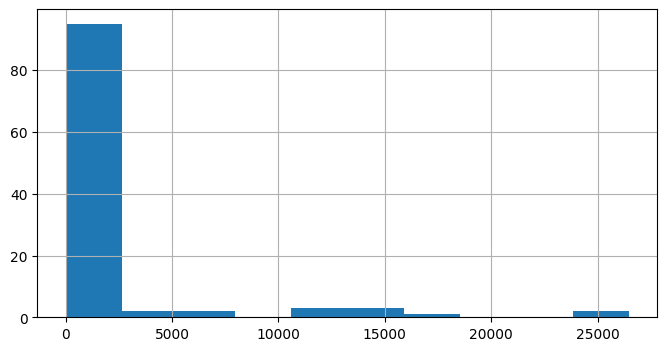

In [244]:
date_hold = 20230424
positions[date_hold]['h_opt'].hist()
tmp = positions[date_hold].loc[positions[date_hold]['h_opt']>=3000]
print(positions[date_hold].loc[positions[date_hold]['h_opt']>0]['h_opt'].sum(), tmp.shape)
tmp[['name', 'close','log-ret','h_privious', 'h_opt']]

### Calculate Exposure and Transaction Costs
We use pca to calculate risk, so we can view residual(alpha) as risk exposure.

<AxesSubplot:title={'center':'Risk Exposure'}>

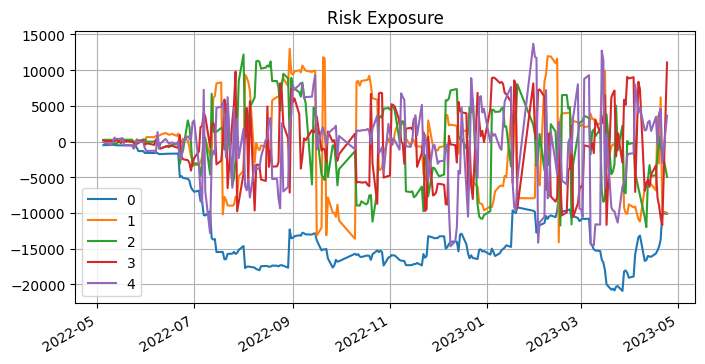

In [235]:
#plt.rcParams['figure.figsize'] = [7, 3]
risk_exposures_df = pd.DataFrame()
risk_exposures = {}
for ii, dt in enumerate(positions.keys()):
    # estimate_returns = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    B = variance_all[dt][1]
    h_opt_i = h_optimal_list[ii]
    risk_exposure = np.matmul(h_opt_i.T, B)
    risk_exposures[dt] = risk_exposure
    risk_exposures_df = risk_exposures_df.append(risk_exposure, ignore_index=True)

#np.sum(risk_exposures)
risk_exposures_df.set_index(pd.to_datetime(calendar, format='%Y%m%d'), inplace=True)
risk_exposures_df.plot(grid=True, title='Risk Exposure')
#risk_exposures_df.head()

### Alpha Exposure

<AxesSubplot:>

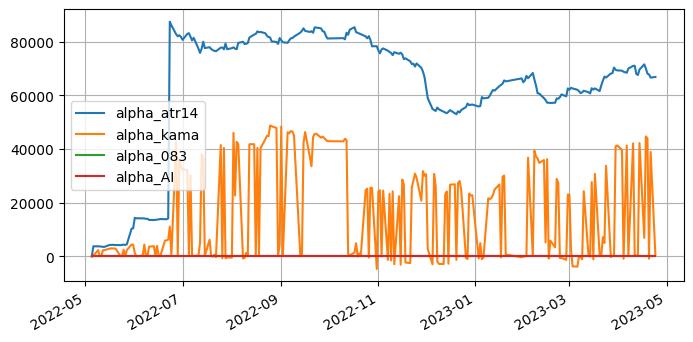

In [236]:
import patsy
import pandas

def colnames(B):
    if type(B) == patsy.design_info.DesignMatrix: 
        return B.design_info.column_names
    if type(B) == pandas.core.frame.DataFrame: 
        return B.columns.tolist()
    return None

def get_B_alpha(universe):
    alpha_factors = factors_from_names(list(universe),'alpha_')
    formula = get_formula(alpha_factors, "returns_2")
    outcome, B_alpha = patsy.dmatrices(formula, universe)
    return B_alpha

alpha_df_ = alpha_df.merge(all_factors[['trade_date','ts_code','returns_2']], on=['trade_date','ts_code'], how='left')
calendar = alpha_df.trade_date.unique()
alpha_exposure_df = pd.DataFrame()
alpha_exposures = {}
for ii, dt in enumerate(calendar):
    alpha_df_i = alpha_df_.loc[alpha_df_.trade_date==dt][['trade_date','ts_code',
                            'alpha_atr14', 'alpha_kama', 'alpha_083', 'alpha_AI', 'returns_2']]
    h_opt_i = h_privious_list[ii]
    B_alpha = get_B_alpha(alpha_df_i)
    
    # alpha_df['alpha_all'] = 0.7 * alpha_df['alpha_AI'] + 0.3*alpha_df['alpha_149'] + 0.1*alpha_df['alpha_010']
    B_alpha = B_alpha * [[0.65, 0.35, 0.0, 0.0]] #* len(alpha_df_.ts_code.unique())
    #alpha_exposure = pd.Series(np.matmul(B_alpha.transpose(), h_opt_i), index=colnames(B_alpha))
    alpha_exposure = pd.Series(np.matmul(B_alpha.transpose(), h_opt_i), index=['alpha_atr14', 'alpha_kama', 'alpha_083', 'alpha_AI'])
    alpha_exposures[dt] = alpha_exposure
    alpha_exposure_df = pd.concat([alpha_exposure_df,alpha_exposure], axis=1)

alpha_exposure_df = alpha_exposure_df.T.reset_index(drop=True)
alpha_exposure_df.set_index(pd.to_datetime(calendar, format='%Y%m%d'), inplace=True)
alpha_exposure_df.plot(grid=True)

457.1265601888528 -7847.172443835617


<AxesSubplot:>

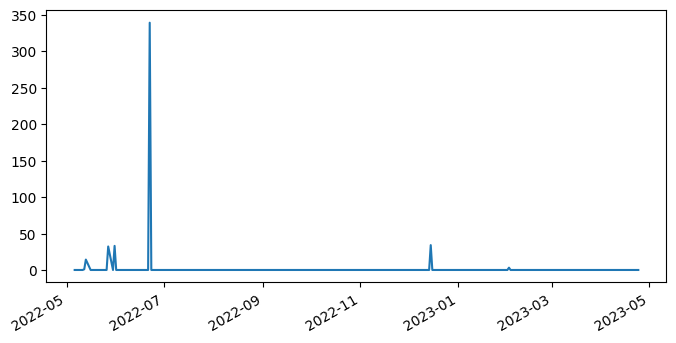

In [237]:
transaction_costs = []
retre_max = 0
Lambda = 3e-6
for i in range(1,len(h_optimal_list)):
    tmp_change = h_optimal_list[i] - h_privious_list[i]
    if min(tmp_change)<retre_max:
        retre_max = min(tmp_change)
    costs = sum(np.dot(tmp_change**2, Lambda)**0.5)
    transaction_costs.append(costs)
print(sum(transaction_costs),retre_max)
pd.Series(transaction_costs, index=pd.to_datetime(calendar[1:], format='%Y%m%d')).plot()

### Cal BenchMark

In [248]:
benchmark_return = pd.read_csv('AI_data/benmark_AI_108.csv')
benchmark_return.columns = ['trade_date', 'log-ret']
benchmark_return.tail()

,trade_date,log-ret
982,20230418,-0.017492
983,20230419,0.010267
984,20230420,0.006796
985,20230421,-0.023961
986,20230424,0.001652


### Profit-and-Loss (PnL)

2023-04-18 00:00:00


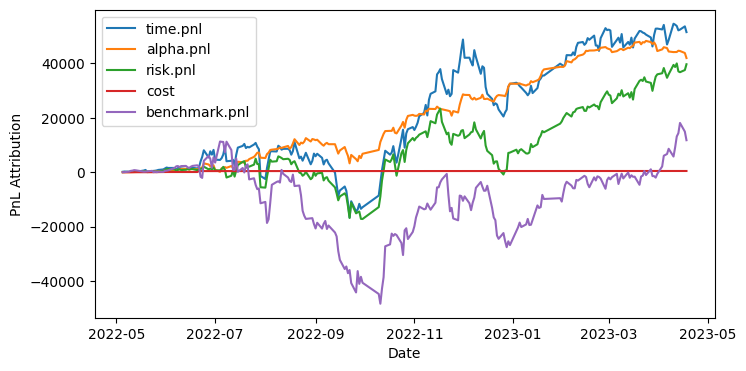

In [265]:
all_factors['date'] = pd.to_datetime(all_factors['trade_date'], format='%Y%m%d')
all_factors = all_factors.set_index(['date']).sort_values(by=['date'])

## assumes v, w are pandas Series 
def partial_dot_product(v, w):
    common = v.index.intersection(w.index)
    return np.sum(v[common] * w[common])

def build_pnl_attribution(): 

    df = pd.DataFrame(index = pd.to_datetime(all_factors['trade_date'].unique(), format='%Y%m%d')).iloc[:-4,:]
    calendar = all_factors.trade_date.unique()
    counter = range(len(calendar))
    for ii, dt, time_i in zip(counter,calendar,df.index):
        # holding frame
        p = positions[dt]
        # alpha f
        #fr = facret[dt][[0,2,5]]
        fr = facret[dt].loc[['alpha_atr14', 'alpha_kama', 'alpha_083', 'alpha_AI']]
        # risk f
        rr = variance_all[dt][2]
        row_universe = all_factors.loc[all_factors.trade_date==dt]
        mf = p[['h_privious', 'h_opt']].merge(row_universe[['ts_code', 'returns_2']], how = 'left', on = "ts_code")  
        mf['returns_2'] = wins(mf['returns_2'], -0.2, 0.2)
        df.at[time_i,"time.pnl"] = np.sum(mf['h_opt'] * mf['returns_2'])
        df.at[time_i,"alpha.pnl"] = partial_dot_product(fr, alpha_exposures[dt])
        #df.at[time_i,"risk.pnl"] = partial_dot_product(rr, risk_exposures[dt])
        df.at[time_i,"risk.pnl"] = np.sum(rr.values * risk_exposures[dt].values)
        df.at[time_i,"cost"] = transaction_costs[ii]
        df.at[time_i,"benchmark.pnl"] = positions[dt]['h_opt'].sum() * \
                            benchmark_return.loc[benchmark_return.trade_date==dt]['log-ret'].values[0]
    
    print(time_i)
    return df

attr = build_pnl_attribution()
for column in attr.columns:
    plt.plot(attr[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('PnL Attribution')
plt.show()

In [266]:
attr['time.pnl'].sum()

51445.99843178394

In [203]:
attr['time.pnl'].cumsum().min()

-16628.426547127463

In [262]:
attr['benchmark.pnl'].sum()

11757.487716162388